In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank
)
import json
import shap
from numpy.lib.stride_tricks import sliding_window_view
from darts.explainability.explainability_result import ComponentBasedExplainabilityResult

In [2]:
result_path = 'results/GRU/'

In [3]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [4]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [5]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_forecasts = None
# Define model parameters

# Set up time series cross-validation with 5 folds, respecting temporal order of data
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTraining the model...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Fit the scaler only on training data to avoid data leakage
    scaler = scaler.fit(train_fold)
    # Transform all time series
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = BlockRNNModel(
        model="GRU",
        model_name=f"model_{fold+1}",
        input_chunk_length=49,
        hidden_dim=216,
        n_rnn_layers=3,
        n_epochs=100,
        batch_size=45,
        dropout=0.27524990279731704,
        add_encoders=encoders,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,    
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.0023425422126866643, "weight_decay": 1e-6},  # Define learning rate and weight decay
    )
    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11}
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    # Generate historical forecasts to evaluate model performance on past data
    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    )


    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Training the model...
Train set: 1389 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6700 XT') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 715 K  | train
6 | fc              | Seq

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 6.303


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.292


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.282


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.278


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.276


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 6.276. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | Hube

O R2 desse fold foi -3.664561990901064

Fold 2

Training the model...
Train set: 2773 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | Hube

O R2 desse fold foi 0.8655855649930541

Fold 3

Training the model...
Train set: 4157 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide


O R2 desse fold foi -inf

Fold 4

Training the model...
Train set: 5541 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 715 K  | train
6 | fc              | Sequential       | 1.7 K  | train
-------------------------------------------------------------
717 K     Trainable params
0         Non-trainable params
717 K     Total params
2.869     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.007. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type    

O R2 desse fold foi -inf

Fold 5

Training the model...
Train set: 6925 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


O R2 desse fold foi -8.276679159148394
O melhor fold foi 2


In [6]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=216, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.27524990279731704, activation=ReLU, model_name=model_2, input_chunk_length=49, n_epochs=100, batch_size=45, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f206f114dd0>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0023425422126866643, 'weight_decay': 1e-06})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE        RMSE         MAE        R2  \
Temperature                    4.906141    2.214981    1.600074  0.891350   
Precipitation_accumulated    331.818990   18.215899    7.051324  0.992012   
Humidity                      19.167932    4.378120    3.404254  0.898965   
Wind_Speed_kmh                 0.059541    0.244010    0.178191  0.803462   
Soil_Moisture              64324.919850  253.623579  158.705094  0.951017   
Soil_Temperature               8.279007    2.877326    1.901534  0.820419   
Wind_Dir_Sin                   0.072557    0.269364    0.167250  0.788092   
Wind_Dir_Cos                   0.118956    0.344899    0.211833  0.812452   

                               SMAPE  
Temperature                11.200774  
Precipitation_accumulated  35.019135  
Humidity                    4.373034  
Wind_Speed_kmh             91.418930  
Soil_Moisture               2.158341

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_1.png


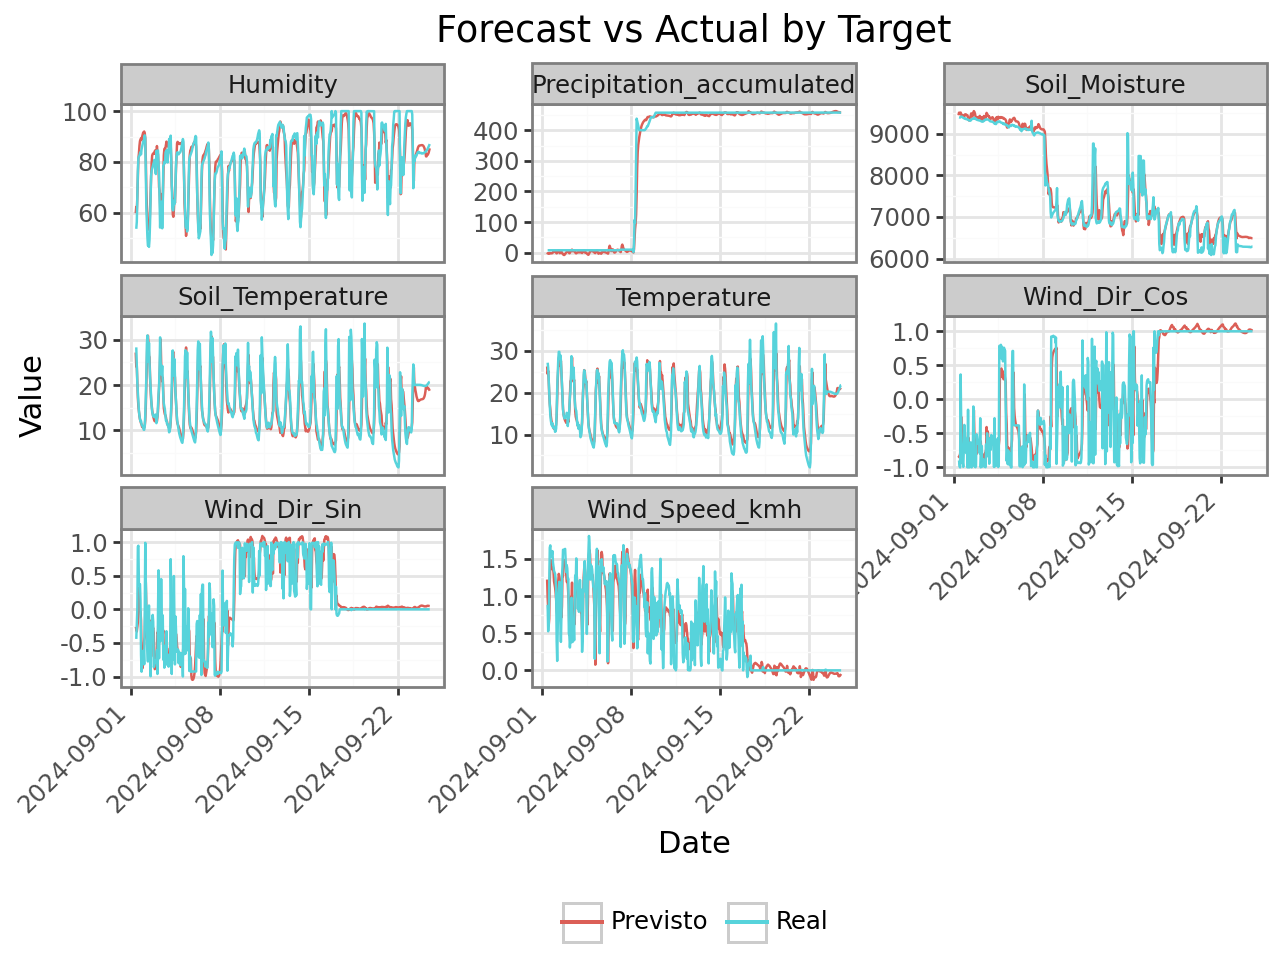

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    14.100325    3.755040    3.002490  0.686594   
Precipitation_accumulated    1474.440992   38.398450   11.027197  0.964149   
Humidity                       64.508546    8.031721    6.624441  0.657227   
Wind_Speed_kmh                  0.115374    0.339667    0.253086  0.620777   
Soil_Moisture              184333.858461  429.341191  306.005701  0.858116   
Soil_Temperature               14.653920    3.828044    2.898855  0.681043   
Wind_Dir_Sin                    0.101353    0.318360    0.203263  0.704439   
Wind_Dir_Cos                    0.202523    0.450025    0.279493  0.679845   

                                SMAPE  
Temperature                 20.428924  
Precipitation_accumulated   51.507865  
Humidity                     8.301146  
Wind_Speed_kmh              98.475609  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_6.png


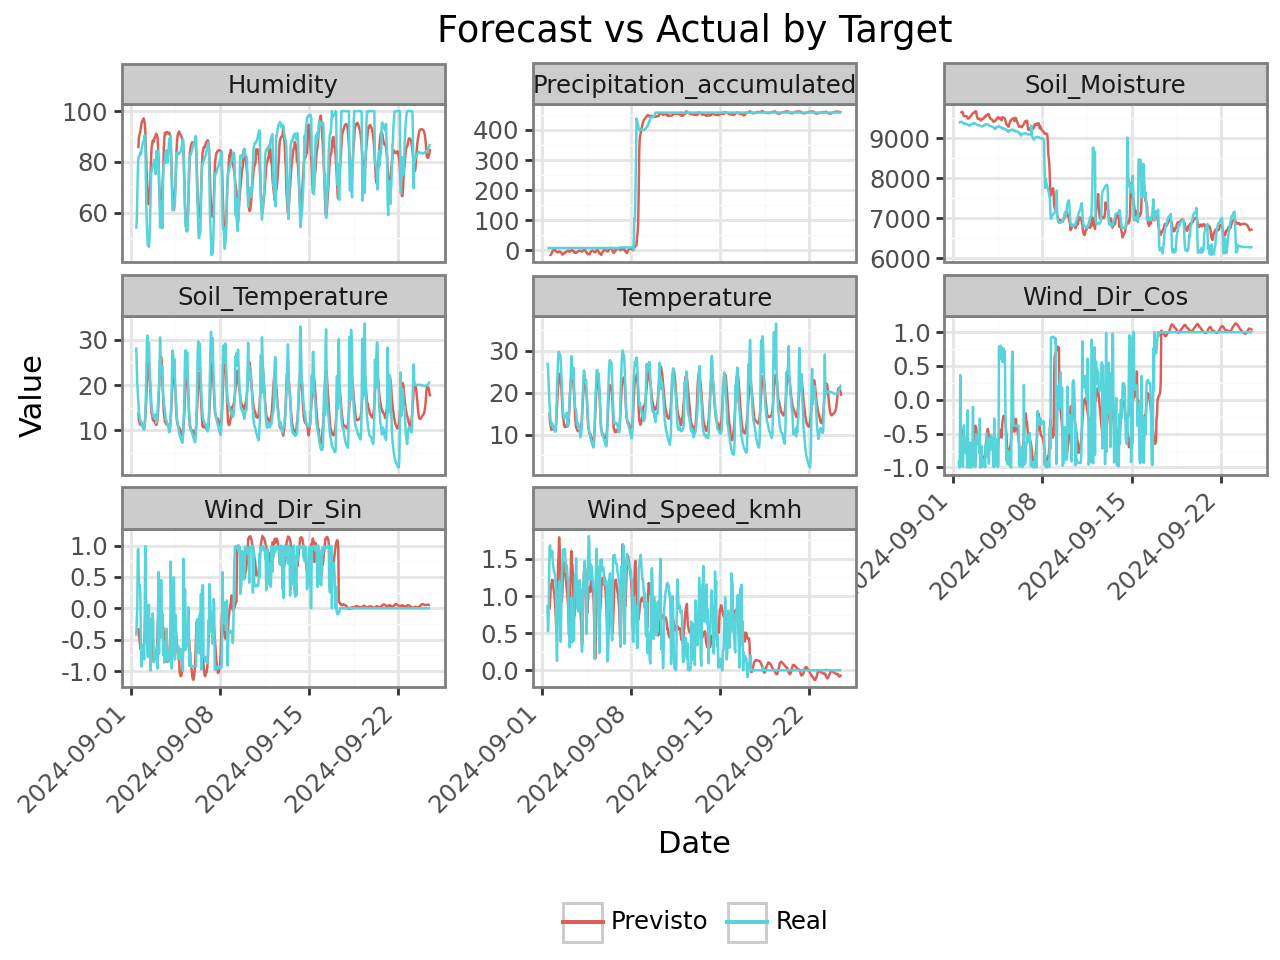

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    17.539631    4.188034    3.397364  0.613544   
Precipitation_accumulated    3429.650458   58.563218   16.266956  0.915269   
Humidity                       88.376114    9.400857    7.903647  0.535451   
Wind_Speed_kmh                  0.116213    0.340901    0.258008  0.607026   
Soil_Moisture              311124.704965  557.785537  408.533521  0.756373   
Soil_Temperature               17.393075    4.170501    3.236436  0.624965   
Wind_Dir_Sin                    0.113299    0.336599    0.218317  0.670555   
Wind_Dir_Cos                    0.235785    0.485577    0.305792  0.625545   

                                SMAPE  
Temperature                 23.226314  
Precipitation_accumulated   56.877524  
Humidity                     9.966515  
Wind_Speed_kmh             100.003211  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_12.png


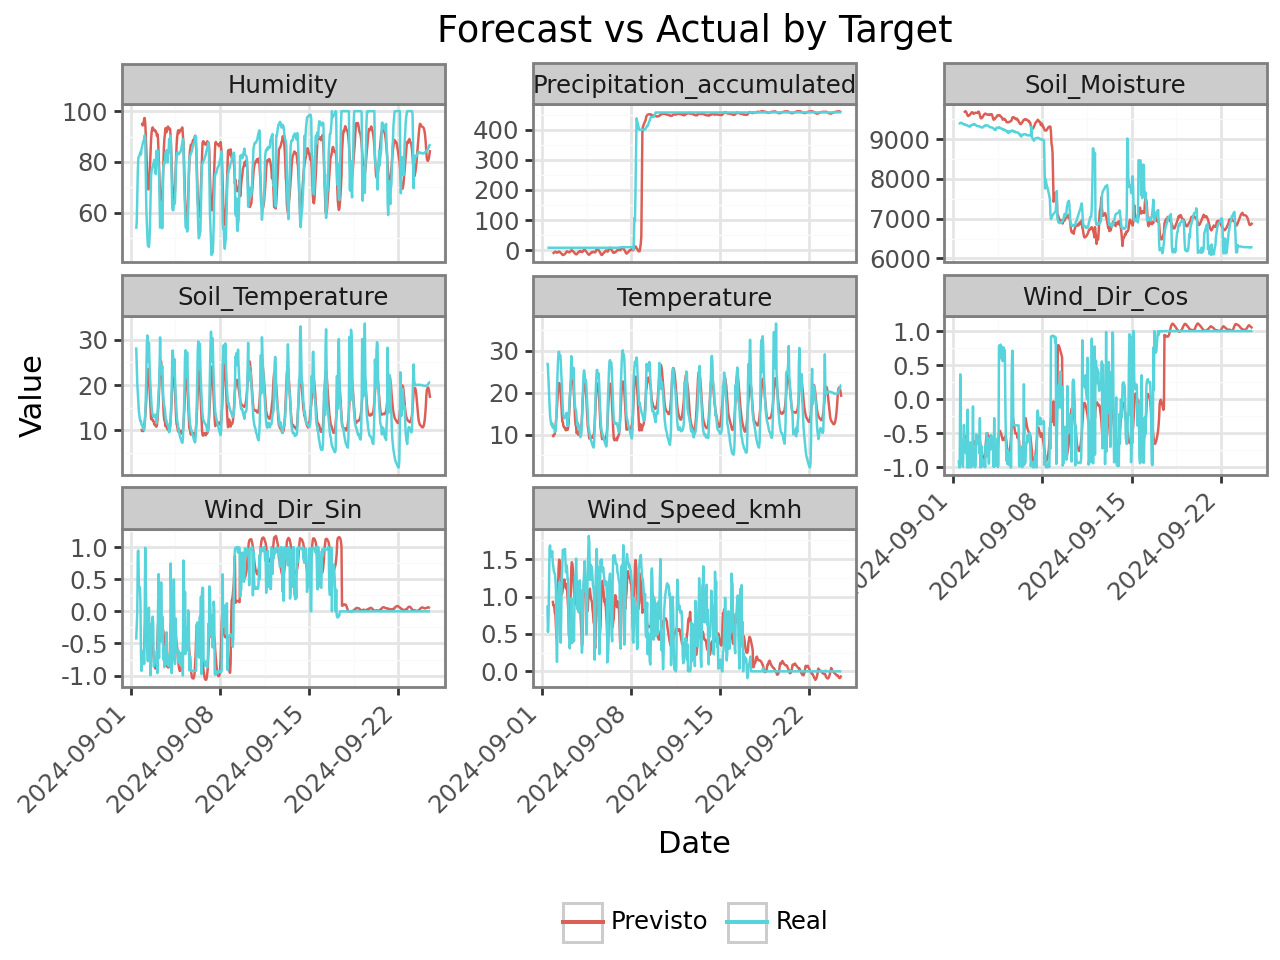

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    21.868255    4.676351    3.888497  0.517520   
Precipitation_accumulated    7226.095057   85.006441   25.333176  0.814990   
Humidity                      125.289556   11.193282    9.684948  0.340885   
Wind_Speed_kmh                  0.132395    0.363861    0.281337  0.548874   
Soil_Moisture              561166.953180  749.110775  570.637688  0.544920   
Soil_Temperature               20.707124    4.550508    3.654764  0.552123   
Wind_Dir_Sin                    0.138701    0.372426    0.246464  0.592259   
Wind_Dir_Cos                    0.320130    0.565801    0.360961  0.488858   

                                SMAPE  
Temperature                 26.795065  
Precipitation_accumulated   59.937826  
Humidity                    12.134141  
Wind_Speed_kmh             104.565464  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_24.png


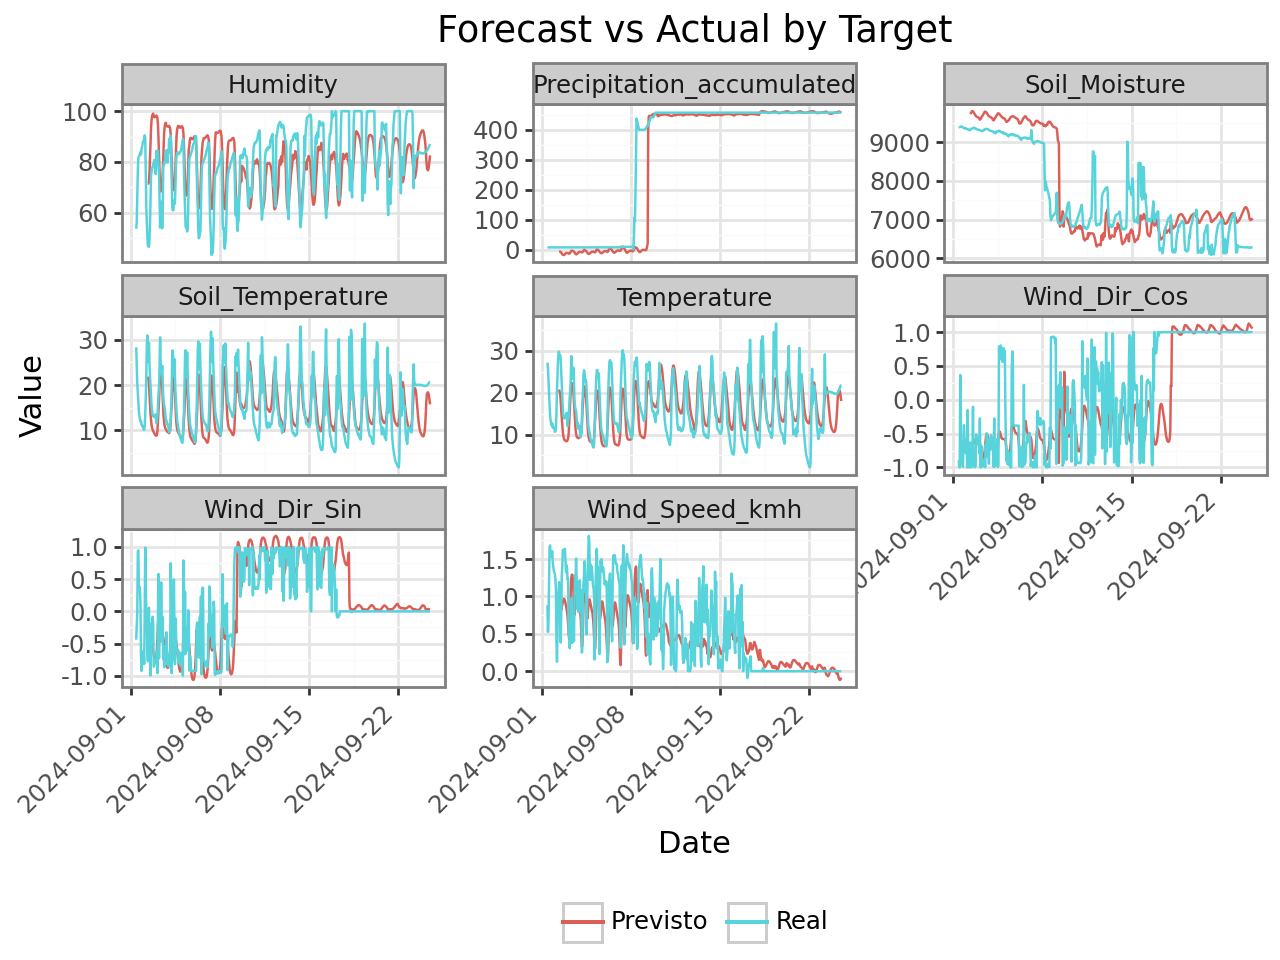

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE         MAE        R2  \
Temperature                3.418155e+01     5.846499    5.045136  0.247483   
Precipitation_accumulated  1.695557e+04   130.213561   46.580622  0.524704   
Humidity                   1.717850e+02    13.106678   11.598355  0.074214   
Wind_Speed_kmh             1.714645e-01     0.414083    0.326538  0.394847   
Soil_Moisture              1.005214e+06  1002.603390  767.664170  0.110356   
Soil_Temperature           3.132186e+01     5.596594    4.726236  0.324510   
Wind_Dir_Sin               3.012623e-01     0.548874    0.375940  0.095298   
Wind_Dir_Cos               4.278260e-01     0.654084    0.445703  0.301972   

                                SMAPE  
Temperature                 36.037180  
Precipitation_accumulated   63.325208  
Humidity                    14.520314  
Wind_Speed_kmh             114.132480  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_48.png


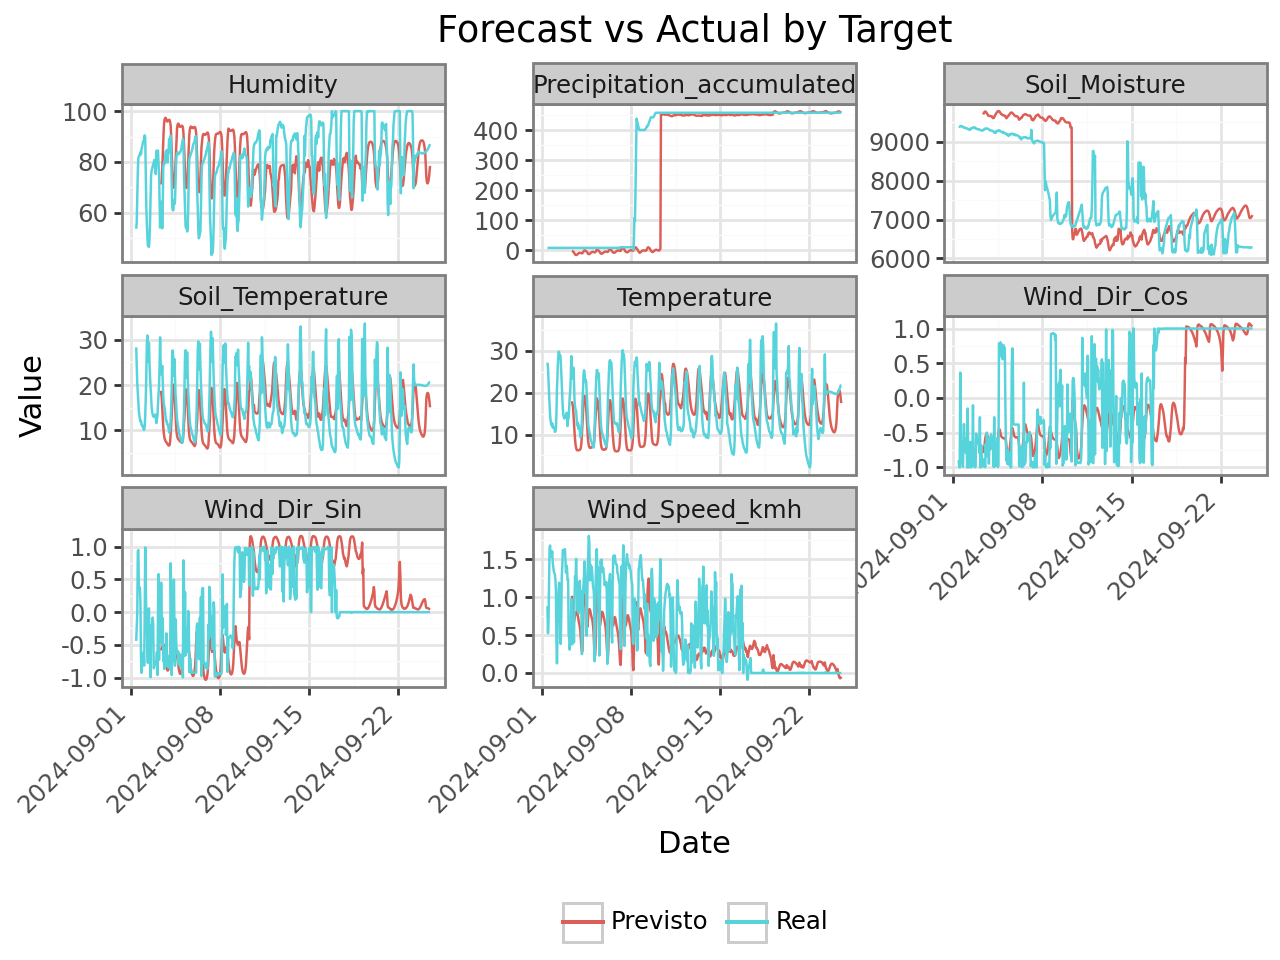

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE         MAE        R2  \
Temperature                4.828260e+01     6.948568    6.135003 -0.047237   
Precipitation_accumulated  2.785567e+04   166.900174   70.527488  0.113217   
Humidity                   2.628945e+02    16.214023   14.365311 -0.400243   
Wind_Speed_kmh             2.028603e-01     0.450400    0.381634  0.285850   
Soil_Moisture              1.376873e+06  1173.402239  893.608424 -0.369287   
Soil_Temperature           4.437927e+01     6.661777    5.816352  0.054630   
Wind_Dir_Sin               6.176526e-01     0.785909    0.629830 -0.940201   
Wind_Dir_Cos               6.748950e-01     0.821520    0.671692 -0.126176   

                                SMAPE  
Temperature                 44.044172  
Precipitation_accumulated   65.599537  
Humidity                    18.262251  
Wind_Speed_kmh             119.777932  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_72.png


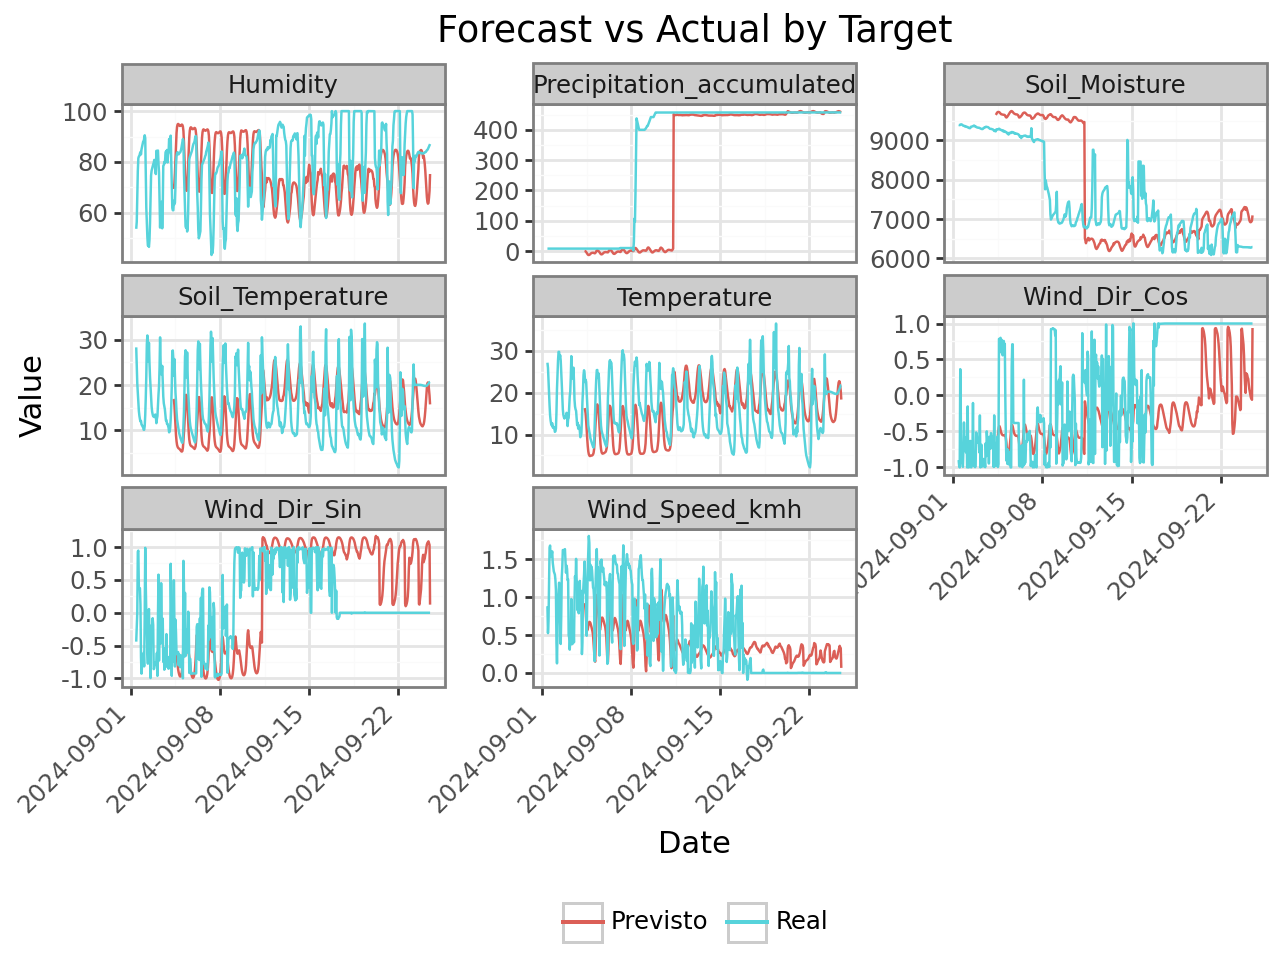

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE          MAE          R2  \
Temperature                9.837030e+01     9.918180     8.982134   -1.165082   
Precipitation_accumulated  8.327932e+04   288.581558   195.128892 -225.277935   
Humidity                   5.580150e+02    23.622341    19.934247   -2.380531   
Wind_Speed_kmh             2.210876e-01     0.470199     0.419277   -0.173027   
Soil_Moisture              2.501355e+06  1581.567124  1234.580369   -7.100295   
Soil_Temperature           1.025897e+02    10.128659     9.157323   -1.243105   
Wind_Dir_Sin               1.396206e+00     1.181612     1.106836   -6.030125   
Wind_Dir_Cos               1.052953e+00     1.026135     0.922946   -1.007782   

                                SMAPE  
Temperature                 65.017563  
Precipitation_accumulated   84.276176  
Humidity                    26.474034  
Wind_Speed_kmh             143.8903

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//previsao_vs_real_168.png


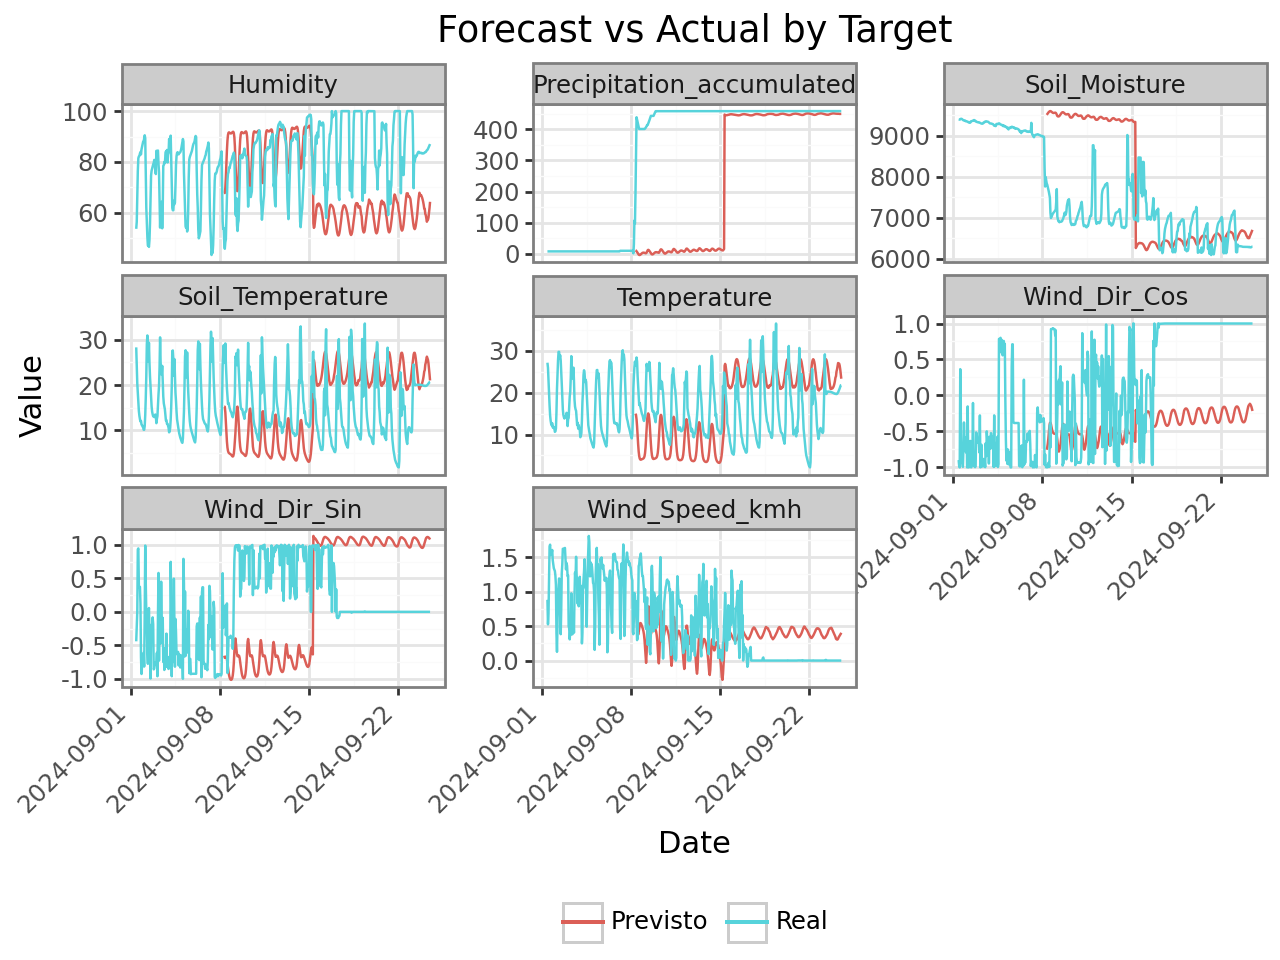

In [8]:
for forecast_horizon in [1,6,12,24,48,72,168]:
    forecasts = model.historical_forecasts(
        best_train_scaled,
        start=0.8,
        forecast_horizon=forecast_horizon,
        stride=1,
        retrain=False,
        last_points_only=True,
        predict_kwargs={"dataloader_kwargs":{"num_workers": 11}}
    )

    forecasts_t = best_scaler.inverse_transform(forecasts)
    s = best_scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Starting time series verification for consistency...")
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], forecasts_t[target]),
            'RMSE': rmse(s[target], forecasts_t[target]),
            'MAE': mae(s[target], forecasts_t[target]),
            'R2': r2_score(s[target], forecasts_t[target]),
            'SMAPE': smape(s[target], forecasts_t[target]),
        }
    metrics_df = pd.DataFrame(metrics).T
    print("\nPerformance metrics:")
    print(metrics_df)

    s_df = s.to_dataframe()
    s_df = s_df.reset_index()
    forecasts_t_df = forecasts_t.to_dataframe()
    forecasts_t_df = forecasts_t_df.reset_index()
    forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
    print(forecasts_t_df.columns)

    plot_columns = ['Timestamp'] + target_columns
    s_melted = s_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    s_melted['type'] = 'Real'

    forecasts_t_melted = forecasts_t_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    forecasts_t_melted['type'] = 'Previsto'

    # Concatena os DataFrames 'Real' e 'Previsto'
    df_combined = pd.concat([s_melted, forecasts_t_melted])

    # Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
    df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

    plot = (
            ggplot(df_combined, aes(x='Date', y='value', color='type'))
            + geom_line()
            + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
            + labs(
        title='Forecast vs Actual by Target',
        x='Date',
        y='Value',
        color='Data Type' # Legend for color
    )
            + theme_bw()
            + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
        legend_position='bottom', # Places legend at the bottom
        legend_title=element_blank(), # Removes legend title
    )
    )

    plot.save(f'{result_path}/previsao_vs_real_{forecast_horizon}.png', width=12, height=10, dpi=300)
    plot.show()

    with open(f'{result_path}/metrics_{forecast_horizon}.json', 'w') as f:
        json.dump(metrics_df.to_dict(), f, indent=4)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

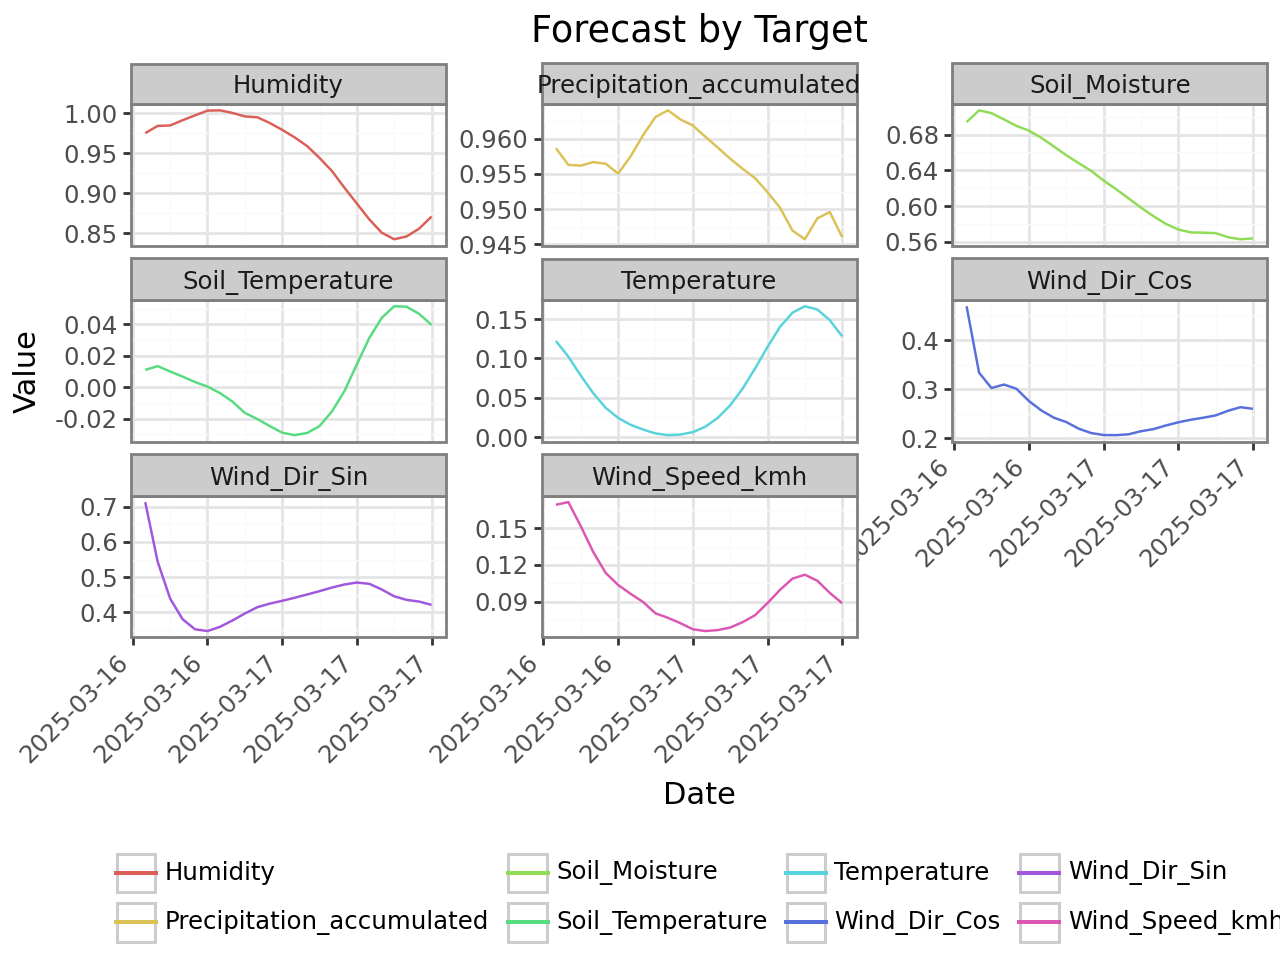

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU//pred_future_24.png


In [9]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
        ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
        + labs(
    title='Forecast by Target',
    x='Date',
    y='Value',
    color='Data Type' # Legend for color
)
        + theme_bw()
        + theme(
    axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
    legend_position='bottom', # Places legend at the bottom
    legend_title=element_blank(), # Removes legend title

)
)
plot.show()
plot.save(f'{result_path}/pred_future_24.png', width=12, height=10, dpi=300)
